# **Finding Lane Lines on the Road** 

by Uki D. Lucas


<img src="http://docs.opencv.org/3.0-beta/_static/opencv-logo2.png" alt="OpenCV" style="width: 150px;"/>




Python 3 and Jupyter have support for greek math symbols.

- alpha : $\alpha$
- beta : $\beta$
- rho : $\rho$
- theta : $\theta$

## Import python packages

This also check if your python enviroment has all the libraries ahead of time.

In [1]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math

# plot images in this notbook
%matplotlib inline 

## Define color constants to be used

In [2]:
# Define RGB colors used in the code
RED = color=[255, 0, 0]
GREEN = color=[0, 255, 0]
BLUE = color=[0, 0, 255]
WHITE = color=[255, 255, 255]
GRAY = color=[192, 192, 192]
VIOLET = color=[153, 51, 255]
ORANGE = color=[255, 128, 0] 

## Import sample image to be used to test flow

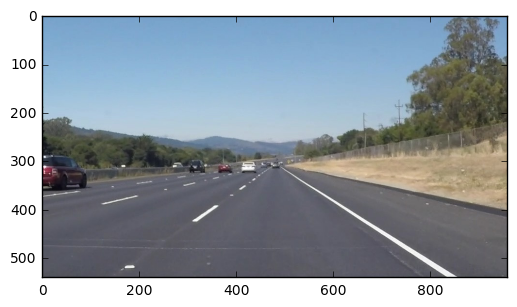

In [3]:
# reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg') # original homework image
#image = mpimg.imread('test_images/bouquet_cyn_curve.jpg') # add on mountain curve
#image = mpimg.imread('test_images/solidWhiteCurve.jpg')
#image = mpimg.imread('test_images/Challenge001.jpg') # intense shadows
#image = mpimg.imread('test_images/Challenge002.jpg') # intense shadows


# printing out some stats and plotting
# print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)
plt.show()

# Convert image to grayscale
Since we are detecting road lines we want to show contrast and we do not care about color at this time (white line vs yellow line)

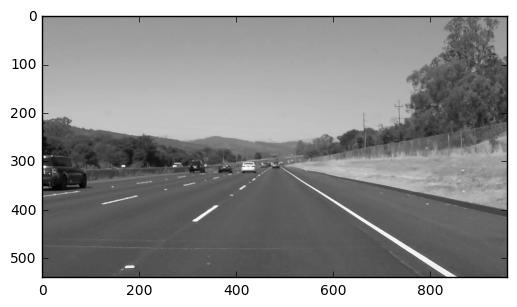

In [4]:
def grayscale(image):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
# TEST the function
image_gray = grayscale(image)
plt.imshow(image_gray, cmap='gray')
plt.show()

# Apply Gaussian Blur

I have tested kernel_size in different values, but generally 5 is good as you do want to have some blur in the image to hide the road imperfections.

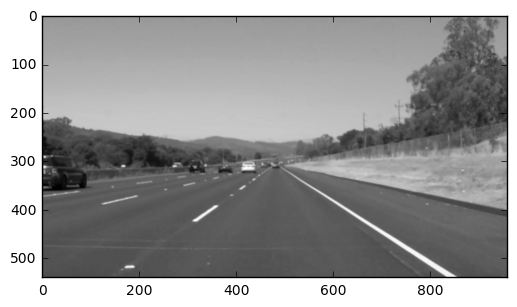

In [5]:
def gaussian_blur(image, kernel_size=5): # 5 is good for homework
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

# Test the function
image_gaussian = gaussian_blur(image_gray, kernel_size=5)
plt.imshow(image_gaussian, cmap='gray')
plt.show()

# Detect "Canny Edges"

This is one of the places where it is easy t overfit for particular conditions.
Generally, I want to see as many line edges as possible but not to see irregular shapes.

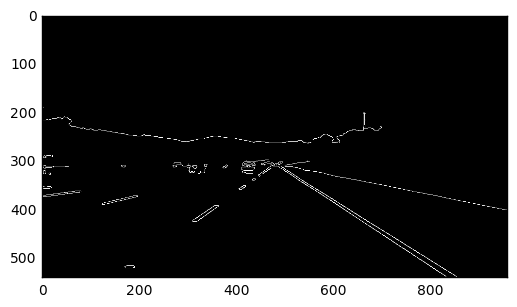

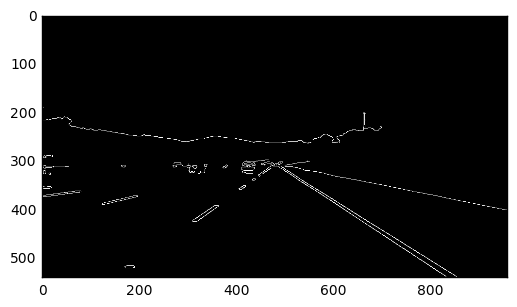

In [6]:
def canny(image, low_threshold=50, high_threshold=250): # homework low_threshold=20, high_threshold=130
    """Applies the Canny transform"""
    return cv2.Canny(image, low_threshold, high_threshold)

# Test the function
image_canny = canny(image_gaussian)
plt.imshow(image_canny, cmap='gray')
plt.show()

# Test the function
image_canny = canny(image_gaussian, low_threshold=50, high_threshold=250)
plt.imshow(image_canny, cmap='gray')
plt.show()

In [7]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# Masking (using polygon vertices)

I have designed a polygon that has fit multiple scenarios (different roads). 
***In the future***, I would like to adjust the shape of the polygon depending on which way the *** average slope (center line)*** is leaning to adjust for turns. I admit that the polygon is biased towards straigh road and gentle curves, for Pikes Peak the polygon has to adjust to the sides.

- on the top do not be afraid to cut off
- in the middle you have to leave some room for turns
- on the bottom start high because of the dashboard
- we are NOT following a center line in this code, so cut it out

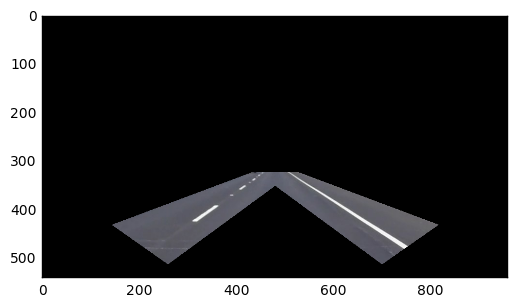

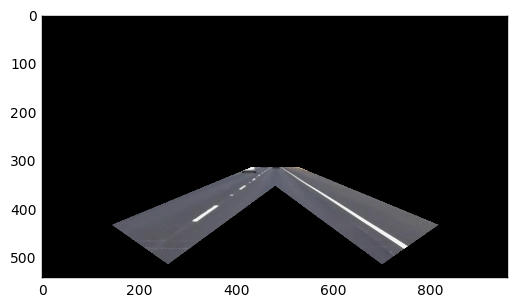

In [8]:


def mask_vertices(image, horizon_offset_percent=-10):
    """
    I decided to go with following polygon 
    after fitting several mountain curve roads.
    It is important not to use pixels as each video may be different.
    horizon_offset = -10 % percent negative mean UNDER the (mid-screen) horizon
    I would like to go as high as possible,
    but in reality only about bottom 40% of the screen is relevant
    """
    height = image.shape[0]
    width = image.shape[1]
    
    horizon_offset = height*horizon_offset_percent/100

    # on the top do not be afraid to cut off
    top_left = (width*0.45, height/2 - horizon_offset)
    top_right = (width-width*0.45, height/2 - horizon_offset)
    
    # in the mid you have to leve some room for turns
    mid_left = (width*0.15, height*0.8) 
    mid_right = (width-width*0.15, height*0.8)
    
    # on the bottom start high because of the dashboard
    bottom_center_left = (width*0.27, height*0.95) 
    bottom_center_right = (width-width*0.27, height*0.95) 
    
    # we are NOT following a center line in this code, so cut it out
    bottom_center = (width/2, height*0.65) 


    # add points clockwise
    vertices = np.array([[ 
                top_left, top_right, 
                mid_right, 
                bottom_center_right, bottom_center, bottom_center_left,
                mid_left 
                 ]], dtype=np.int32)
    return vertices


# Test the region_of_interest function
image_mask = region_of_interest(image, mask_vertices(image))
plt.imshow(image_mask, cmap='gray')
plt.show()

image_mask = region_of_interest(image, mask_vertices(image, horizon_offset_percent=-8))
plt.imshow(image_mask, cmap='gray')
plt.show()

# Apply mask to "Canny Edges"

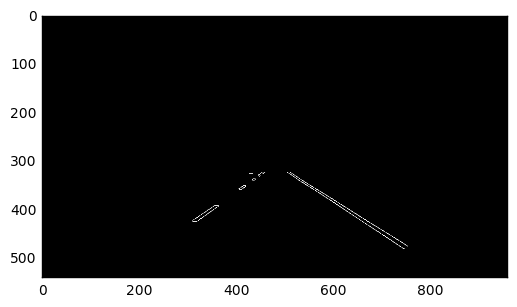

In [9]:
image_mask = region_of_interest(image_canny, mask_vertices(image))
plt.imshow(image_mask, cmap='gray')
plt.show()


# Arrange coordinates in each line so x is above y

For sanity sake when calculating things, I adjusted all lines so:
- x1, y1 coordinated were always above
- x2, y2 coordinated were always below

In [10]:
def arrangeLineCoordinates(line):
    """
    This method enforces that given line,
    has x1, y1 on TOP
    and x2, y2 on the BOTTOM of the image.
    
    It is user responsibility to test
    if line is a valid object.
    I have no way to know what to return otherwise.
    """
    try:
        for x1,y1,x2,y2 in line:
            if y1 > y2:
                # print("WARNING y1 > y2 swapping the order")
                temp_x2 = x1
                temp_y2 = y1
                temp_x1 = x2
                temp_y1 = y2

                x1 = temp_x1
                x2 = temp_x2
                y1 = temp_y1
                y2 = temp_y2   
                line = np.array([[x1, y1, x2, y2]], np.int32)
    except ValueError:
        #print("Provided line has unexpected values", line)
        line = np.array([[0, 0, 0, 0]], np.int32)
    except TypeError:
        # Use this as visual clue that line is not correct
        #print("Provided line has unexpected type", type(line))
        line = np.array([[0, 0, 0, 0]], np.int32)
                
    return line
  

# Draw lines

This method is pretty much close to original, except for error handling, e.g. sometimes no lines are detected.

In [11]:
def draw_lines(image, lines, color=WHITE, thickness=1):
    """   
    Lines are drown over the image, i.e. mutates the image.
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    if lines is not None: # no point processing is no lines were found
        for line in lines:
            try:
                if line is not None: # TypeError: 'NoneType' object is not iterable
                    line = arrangeLineCoordinates(line)
                    for x1,y1,x2,y2 in line:
                        cv2.line(image, (x1, y1), (x2, y2), color, thickness)
            except ValueError:
                #print("Oops!  draw_lines", line)
                cv2.line(image, (0, 0), (0, 0), color, thickness)
            except TypeError:
                #print("Oops!  draw_lines", line)
                cv2.line(image, (0, 0), (0, 0), color, thickness)

# Calculate Slopes for LEFT and RIGHT edge

I have used a function to calculate slope for each line to determine if it belongs to LEFT or RIGHT side, and to throw away these that are clearly wrong.

In [12]:
def calc_slope(x1, y1, x2, y2):        
    rise = y2 - y1
    
    run = x2 - x1
    try:
        slope = rise/run
        return slope
    except ZeroDivisionError:
        print("ZeroDivisionError: calc_slope the slope cannot be calculated for a VERTICAL LINE.")
    

# TEST
print(calc_slope(-1, 2, 1, 3))
print(calc_slope(2, 2, 1, 3))
print(calc_slope(1, 2, 1, 3))

0.5
-1.0
ZeroDivisionError: calc_slope the slope cannot be calculated for a VERTICAL LINE.
None


# Average slope values

I have made use of averageing techniques in couple of versions of this project for slopes and y_intercepts and I plan in the future to use that technique, the effect is smoothness. However, using averages is dangerous and gives you a "fake" lines, so there is definitely a tradeoff.

In [13]:
def mean(numbers):
    if 0 == max(len(numbers), 1):
        return float("NaN")
    return float(sum(numbers)) / max(len(numbers), 1) #TODO check division by zero

# Rounding algebra loats to integers (pixels)

When calculating slope we end up with floats, when calculating coordinates from slopes we need to convers results back to integers. This method is not generic as it handles infinity in special way (as a large number).

In [14]:
def round_int(x):
    if x == float("inf") or x == float("-inf"):
        # return float('nan') # or x or return whatever makes sense
        return 1000
    return int(round(x))

# TEST
print(round_int(174.919753086))
print(round_int(0))
print(round_int(float("inf")))
print(round_int(float("-inf")))

175
0
1000
1000


# Calculate y-intercept

Similarly to slope, the calculation of y-intercept is essential to solve for coordinates.
I needed to handle infinity and Nan as well as division by zero.

In [15]:
def calc_y_intercept(slope, x, y):
    return y - (x * slope)

#test
slope = -(2/3)
x = -3
y = 3
print(calc_y_intercept(slope, x, y))


slope = -(2/3)
x = 3
y = -1
print(calc_y_intercept(slope, x, y))

1.0
1.0


In [16]:
def calc_x(slope, y, y_intercept):
    
    if math.isnan(slope): # vertical line cannot have a slope
        return float('nan')
    if slope == float('Inf') or slope == -float('Inf'):
        return float('nan')
    if y_intercept == float('Inf') or y_intercept == -float('Inf'):
        return float('nan')
    
    result = 0 # temp
    try:
        if slope == 0: # flat line
            slope = 0.01 # avoid division by zero, result will be a large number, almost flat line
        x = (y - y_intercept)/slope
        result = round_int(x)
    except ValueError:
        print("ValueError: calc_x That was no valid number.  slope", slope, "y", y, "y_intercept", y_intercept)
    return   result

# TEST
y = -1
y_intercept = 1

slope = -(2/3)
# 3 expected
print("x =", calc_x(slope, y, y_intercept))

slope = 1
print("x =", calc_x(slope, y, y_intercept))

slope = 0
print("x =", calc_x(slope, y, y_intercept))

x = 3
x = -2
x = -200


# Use Hugh algorithm to connect dots (lines)

This part of the code was the BULK of work (together with the sides). 
I decided that a plausible technique would be to:

- divide Hough lines into LEFT, RIGHT and IRRELEVANT based on the slope and intersection of the bottom
- find the longest detected line on each side
- extend it to the bottom
- extend it to the top-most detected point on this side
- draw different types of lines in different colors

# Sort lines to belong to LEFT or RIGHT, or irrelevant (color coded) buckets

This method is essential as is divides lines to sides of the road and eliminates the irrelevant lines.
Please take in consideration that I consider the slope value as well as where the line intersects the bottom of the image. If the line is way off to the side I cansider it irrelevant.

In [17]:
def side(image, line):
    """
    This function determines if line
    should be procesed as "left", "right"
    or rejected entirely as irrelevant.

    side: LEFT, slope -0.923076923077
    side: RIGHT, slope 0.65
    """
    

    width = image.shape[1] # right of the image frame
    height = image.shape[0] # bottom of the image frame

    for x1,y1,x2,y2 in arrangeLineCoordinates(line):
        slope = calc_slope(x1,y1,x2,y2)
        intercept = calc_y_intercept(slope, x1, y1)
        # I am interested where is x (left, or right)
        # if you extend the line to the bottom of the image
        y2 = height
        x2 = calc_x(slope, y2 , intercept) 

        if (0 < x2 < width/2 - width*0.1) and (-0.95 < slope < -0.20) : # LEFT negative
            return "left"
        elif  (width/2 + width*0.1 < x2 < width ) and (0.8 > slope > 0.25): # RIGHT positive
            # print("side: RIGHT, slope", slope)
            return "right"
        else:
            # print("irrelevant, slope", slope, "x2", x2)
            return "irrelevant" # the line extends off screen, to be tested

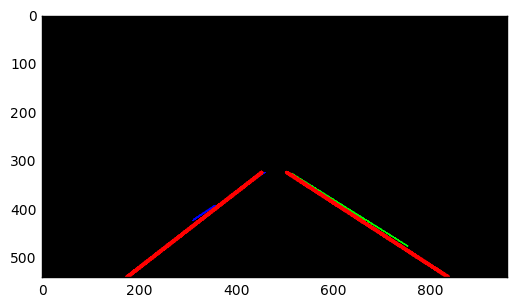

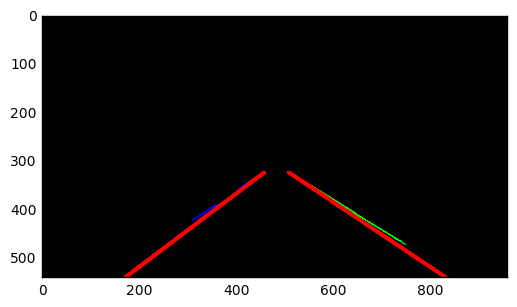

In [18]:
def hough_lines(image, rho=2, theta=np.pi/180, threshold=20, min_line_len=30, max_line_gap=20):
    """
    - rho ρ is the distance from the origin
    - theta θ is the angle
    - min_line_len minimum length of a line that will be created
    - max_line_gap maximum distance between segments that will be connected to a single line
    - threshold increasing(~ 50-60) will rule out the spurious lines.
    defines the minimum number of intersections in a given grid cell that are required to choose a line.)
    """
    lines = cv2.HoughLinesP(image, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
    if lines is None: # no point processing if no lines were found
        return image
    
    width = image.shape[1] # right of the image frame
    height = image.shape[0] # bottom of the image frame

    left_longest_line = 0
    right_longest_line = 0

    relevant_hough_lines_left = [] 
    relevant_hough_lines_right = [] 
    rejected_hough_lines = []
    longest_lines_left = []
    longest_lines_right = []

    longest_right = 0
    longest_left = 0

    for line in lines:
        for x1,y1,x2,y2 in arrangeLineCoordinates(line):

            # get vertical HEIGHT of this line 
            y_difference = abs(y2 - y1)

            # Categorize the lines to LEFT | RIGHT 
            side_detected = side(image, line)
            
            if "left" == side_detected:
                relevant_hough_lines_left.append(line)
                if y_difference > longest_left:
                    left_longest_line = line
                    longest_left = y_difference
                    
            elif  "right" == side_detected:
                relevant_hough_lines_right.append(line)
                if y_difference > longest_right:
                    right_longest_line = line
                    longest_right = y_difference

            else:
                rejected_hough_lines.append(line) # WHITE

    longest_lines_left.append(left_longest_line)  # ORANGE 
    longest_lines_right.append(right_longest_line) # ORANGE 
    
    # draw a blank black image
    image_lines = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    
    # draw color-coded HOUGH lines
    # Most of the time I do not want to draw all of the WHITE lines   
    #draw_lines(image_lines, lines, color=WHITE, thickness=2)
    draw_lines(image_lines, relevant_hough_lines_left, color=BLUE, thickness=2)
    draw_lines(image_lines, relevant_hough_lines_right, color=GREEN, thickness=2)
    draw_lines(image_lines, longest_lines_left, color=ORANGE, thickness=2)
    draw_lines(image_lines, longest_lines_right, color=ORANGE, thickness=2)
    
    
    # if no higher point is found I will draw up to this
    highest_y = round_int(height*0.8) 


    
    # LEFT
    slopes_left = []
    left_highest_y = highest_y
    for line in relevant_hough_lines_left:
        for x1,y1,x2,y2 in arrangeLineCoordinates(line):
            slope = calc_slope(x1,y1,x2,y2)
            slopes_left.append(slope)
            if y1 < left_highest_y: # find highest relevant y LEFT
                left_highest_y = y1
                
                    
    # RIGHT
    slopes_right = []
    right_highest_y = highest_y 
    for line in relevant_hough_lines_right:
        for x1,y1,x2,y2 in arrangeLineCoordinates(line):
            slope = calc_slope(x1,y1,x2,y2)
            slopes_right.append(slope)
            if y1 < right_highest_y: # find highest relevant y RIGHT
                right_highest_y = y1
    
    # Draw EXTENDED LONGEST lines in BLUE
    for line in longest_lines_left:
        try:
            for x1,y1,x2,y2 in arrangeLineCoordinates(line):
                slope = calc_slope(x1,y1,x2,y2)
                intercept = calc_y_intercept(slope, x1, y1)
                # I am interested in the UPPER most relevant point y
                y1 = left_highest_y # highest point to draw LEFT
                x1 = calc_x(slope, y1, intercept)

                # I am interested where is x (left, or right)
                # if you extend the line to the bottom of the image
                y2 = height
                x2 = calc_x(slope, y2, intercept)
                # Draw PREDICTED BLUE line
                cv2.line(image_lines, (x1, y1), (x2, y2), color=RED, thickness=8)
        except ValueError:
            # print("ValueError: provided line has bad values", line)
            cv2.line(image_lines, (0, 0), (0, 0), color=WHITE, thickness=1)
        except TypeError:
            # Giving myself a visual clue 
            # print("TypeError: the provided line is of a wrong type", type(line))
            cv2.line(image_lines, (0, 0), (0, 0), color=WHITE, thickness=1)
            
    # Draw EXTENDED LONGEST lines in BLUE
    for line in longest_lines_right:
        try:
            for x1,y1,x2,y2 in arrangeLineCoordinates(line):
                slope = calc_slope(x1,y1,x2,y2)
                intercept = calc_y_intercept(slope, x1, y1)
                # I am interested in the UPPER most relevant point y
                y1 = right_highest_y # highest point to draw LEFT
                x1 = calc_x(slope, y1, intercept)

                # I am interested where is x (left, or right)
                # if you extend the line to the bottom of the image
                y2 = height
                x2 = calc_x(slope, y2, intercept)
                # Draw PREDICTED BLUE line
                cv2.line(image_lines, (x1, y1), (x2, y2), color=RED, thickness=8)
        except ValueError:
            # print("ValueError: provided line has bad values", line)
            cv2.line(image_lines, (0, 0), (0, 0), color=WHITE, thickness=1)
        except TypeError:
            # Giving myself a visual clue 
            # print("TypeError: the provided line is of a wrong type", type(line))
            cv2.line(image_lines, (0, 0), (0, 0), color=WHITE, thickness=1)
    
    
    draw_lines(image_lines, rejected_hough_lines, color=VIOLET, thickness=1)
    
    return image_lines


# TEST  
image_hough_lines = hough_lines(image_mask)
plt.imshow(image_hough_lines)
plt.show()


image_hough_lines = hough_lines(image_mask, rho=2, theta=np.pi/180, threshold=25, min_line_len=25, max_line_gap=20)
plt.imshow(image_hough_lines)
plt.show()

In [19]:
print("all Hough lines - WHITE")
print("relevant Hough lines right - GREEN")
print("relevant Hough lines left - RED")
print("rejected Hough lines - GRAY")
print("longest lines - ORANGE")

all Hough lines - WHITE
relevant Hough lines right - GREEN
relevant Hough lines left - RED
rejected Hough lines - GRAY
longest lines - ORANGE


# Overlay detected lines over original image

In the first try I had separate masks for left and right, this made things very simple, but did not work very well in sharp turns.
I have tried with several values, but overall effect was good enough with the values below (close to original).

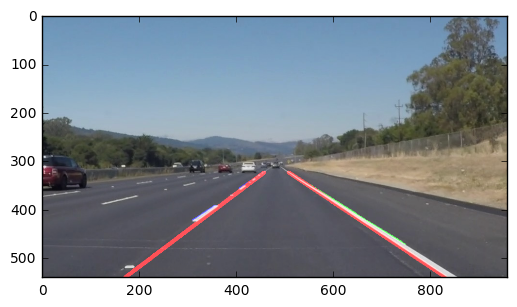

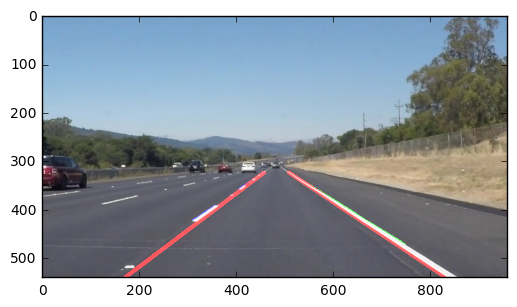

In [20]:
def weighted_img(image_mask, image_original, α=0.9, β=1., λ=0.1):
    """
    The result image is computed as follows:
    image_original * α + image_mask * β + λ
    The image_original and image_mask must be the same shape.
    
    Beta β= affects the background
    """
    return cv2.addWeighted(image_original, α, image_mask, β, λ)

# Test function
image_weighted = weighted_img(image, image_hough_lines, α=0.9, β=0.9, λ=0.5)
plt.imshow(image_weighted, cmap='gray')
plt.show()

image_weighted = weighted_img(image, image_hough_lines, α=0.9, β=1., λ=0.1)
plt.imshow(image_weighted, cmap='gray')
plt.show()

# Combine all above functions into image-processing pipeline

After figuring out all my default parameters (described above), combining the pipline could be made clean by skipping all the unnecessary parameters.

Please note that the TEST pipeline is above with each function processing the test image, and the PRODUCTION pipeline is below using default parameters. Each step of the pipline takes an image that was modified above. 

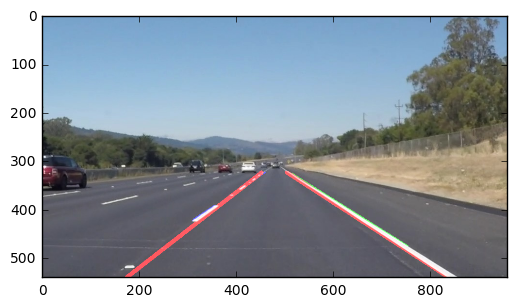

In [21]:
def process_image(image):
    
    # NOTE: The output you return should be a color image (3 channel) 
    # for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    image_copy = np.copy(image) 
    image_gray = grayscale(image_copy)
    image_gaussian = gaussian_blur(image_gray)
    image_canny = canny(image_gaussian)
    image_mask = region_of_interest(image_canny, mask_vertices(image_canny))
    image_hough_lines = hough_lines(image_mask)
    image_weighted = weighted_img(image, image_hough_lines)

    return image_weighted

image_result = process_image(image)
plt.imshow(image_result)
plt.show()

## Test image-processing pipline on few static images



### Read images from local directory

In [22]:
import os
image_list = os.listdir("test_images/")
image_list

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

### For each jpg apply the image-processing pipeline and display results

processing image solidWhiteCurve.jpg


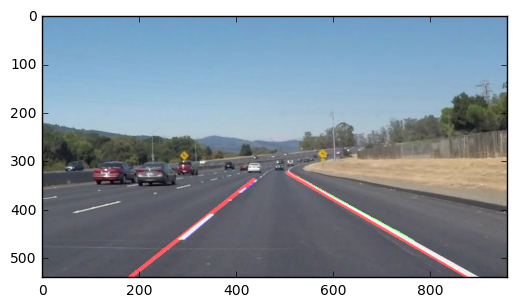

processing image solidWhiteRight.jpg


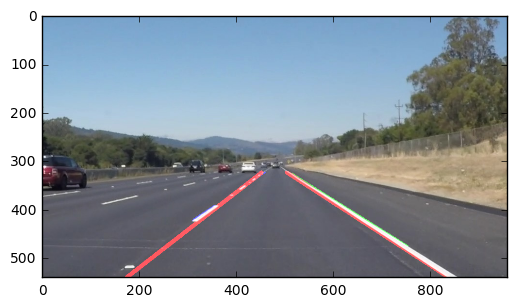

processing image solidYellowCurve.jpg


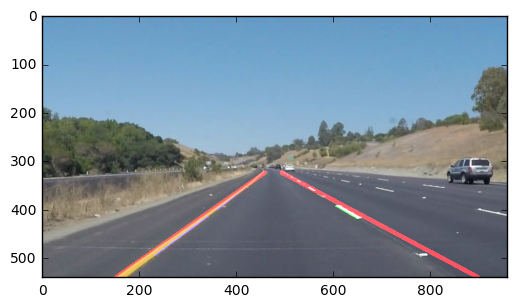

processing image solidYellowCurve2.jpg


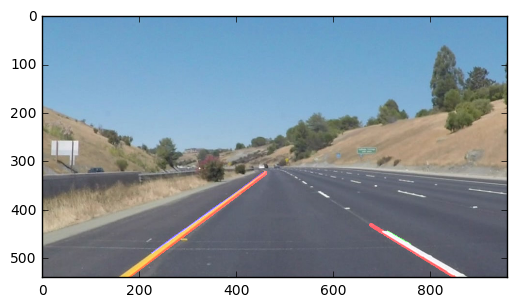

processing image solidYellowLeft.jpg


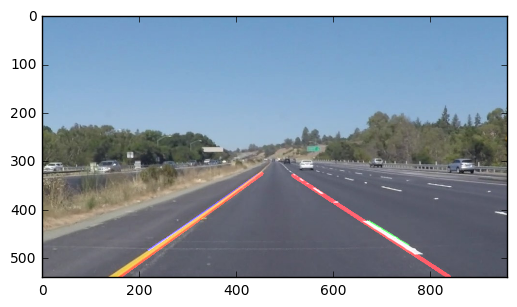

processing image whiteCarLaneSwitch.jpg


/Users/ukilucas/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in int_scalars


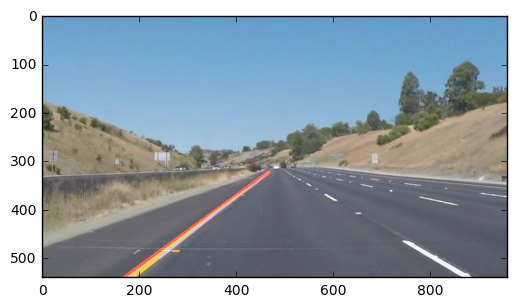

In [23]:
for name in image_list:
    # print("fetching image", name)
    if ".jpg" in name: # name sure we are not trying to read Mac .DS_Store
        print("processing image", name)
        image = mpimg.imread('test_images/' + name)
        image_result = process_image(image)
        plt.imshow(image_result)
        plt.show()

run your solution on all test_images and make copies into the test_images directory).

## Test the image-processing pipline on mp4 video


In [24]:
# Import everything needed to edit/save/watch video clips

from moviepy.editor import VideoFileClip
from IPython.display import HTML

# ERROR
# NeedDownloadError                         Traceback (most recent call last)
# /Users/ukilucas/anaconda3/lib/python3.5/site-packages/imageio/plugins/ffmpeg.py in get_exe()
#      81             exe = get_remote_file('ffmpeg/' + FNAME_PER_PLATFORM[plat],

# TO FIX THE ERROR
# >>> import imageio
# >>> imageio.plugins.ffmpeg.download()

## Current code performs at about 52 frames per second (MacBook Pro i7)

This code is not optimized for multi-core architecture.


Let's try the one with the solid white lane on the right first ...

In [25]:
white_output = 'white.mp4'
clip = VideoFileClip("solidWhiteRight.mp4")
new_clip = clip.fl_image( process_image )
%time new_clip.write_videofile(white_output, audio=False)
# before optimzation 221/222 [00:07<00:00, 31.22it/s]

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:04<00:00, 52.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 4.55 s, sys: 185 ms, total: 4.74 s
Wall time: 4.73 s


0


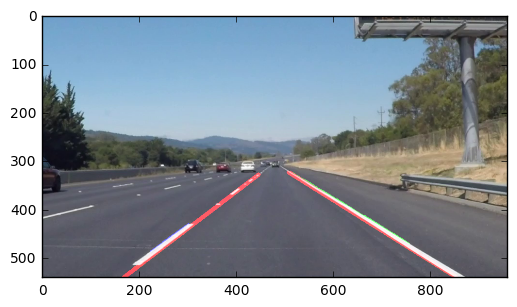

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
1


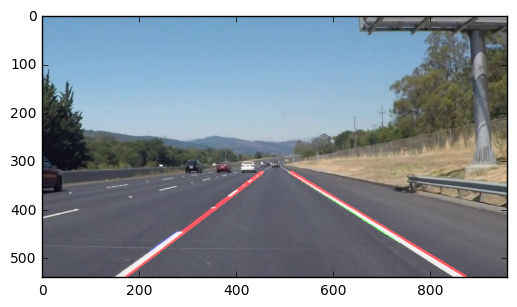

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs
2


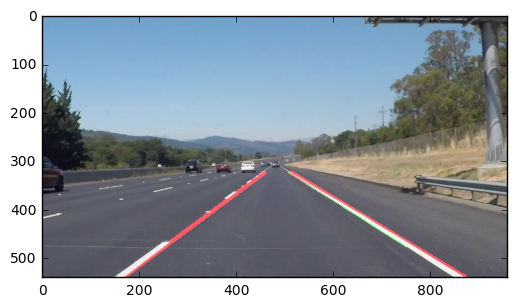

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs
3


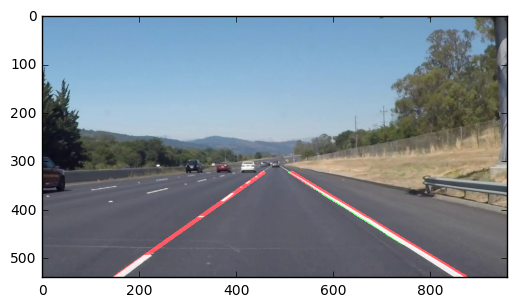

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs
4


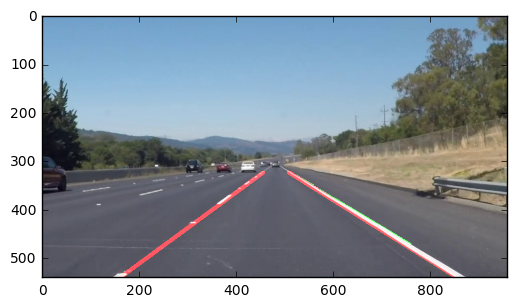

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs


In [26]:
clip = VideoFileClip("solidWhiteRight.mp4")
i=0
for frame in clip.iter_frames():
    print(i)
    image_result = process_image(frame)
    plt.imshow(image_result, cmap='gray')
    plt.show()
    %time  i+=1
    if i == 5:
        break


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [28]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)
# before optimization 681/682 [00:23<00:00, 29.58it/s]

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:13<00:00, 50.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 14.3 s, sys: 536 ms, total: 14.8 s
Wall time: 14 s


In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

# Reflections


- I would like to compute the the HORIZON point as intersection of the 2 slopes LEFT and RIGHT and ignore points above it dynamically
- I would like to adjust the shape of the mask polygon depending on the turn
- Depending on the final need of this exercise I might add some averaging to SMOOTH the prediction lines
- I would like to consider only the lines that "stack on top of each other" which means that y coordinates form a sequence (one line above the other) and slopes are very similar and y-intersects are very similar
- I would like to use a CURVE (quadratic function) instead of straigh line (linear funcion) because road is almost never straight (sorry Nebraska!)
- I have run this code agaist the curvy road up the Pikes Peak and would love to continue working on that until perfect.

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [30]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)
# before optimization 251/251 [00:16<00:00, 14.86it/s]
# 251/251 [00:13<00:00, 19.28it/s]

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:11<00:00, 22.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 10.9 s, sys: 1.02 s, total: 11.9 s
Wall time: 12.2 s


# Comments to challenge

Please note that I extend the lines ONLY to the TOP-MOST point detected on each side and not to some artificial height (e.g. horizon, screen height/2), which would be much easier. 

This was a concious decision as the SHORTER line indicates that computer is NOT SURE and the car should:
- slow down
- favor alternative means to judge distance from objects 

In [31]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [32]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>